# TM10007 Assignment ECG data, Group 4

## 1. Importing the modules, and loading/ cleaning the data

In [1]:
# Importing all the relevant modules
import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, f1_score, precision_recall_curve
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from deap import base, creator, tools, algorithms

# Downloading the data
with zipfile.ZipFile('ecg/ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Converting to features and labels
features = data.drop(columns=['label'])
labels = data['label']

# Count the distribution of labels
label_counts = labels.value_counts()
label_percentages = label_counts / len(labels) * 100
label_distribution = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentages.round(2)
})
print("\nLabel distribution:")
print(label_distribution)

# Checking for missing and infinite values
print("Total missing values:", features.isnull().sum().sum())
print("Total infinite values:", np.isinf(features.to_numpy()).sum())

The number of samples: 827
The number of columns: 9001

Label distribution:
       Count  Percentage (%)
label                       
0        681           82.35
1        146           17.65
Total missing values: 0
Total infinite values: 0


### 1.1 Check for missing data

In [2]:
def handle_missing_values(data, feature_threshold=0.3, patient_threshold=0.3):
    """
    Handles missing values in the dataset by:
    1. Removing features (columns) with more than a given percentage of missing values.
    2. Removing patients (rows) with more than a given percentage of missing values.
    3. Imputing remaining missing values using the median per feature.
    
    Parameters:
        data (pd.DataFrame): The input dataset.
        feature_threshold (float): Maximum allowed proportion of missing values per feature before removal.
        patient_threshold (float): Maximum allowed proportion of missing values per patient before removal.
    
    Returns:
        pd.DataFrame: Cleaned dataset with missing values handled.
    """

    total_missing = data.isnull().sum().sum()
    print(f"Total missing values: {total_missing}")

    if total_missing == 0:
        return data

    print("Handling missing values...")

    # Define absolute thresholds based on proportions
    feature_missing_threshold = feature_threshold * len(data)  
    patient_missing_threshold = patient_threshold * len(data.columns)  

    # Step 1: Remove features with more than the allowed missing value percentage
    features_to_drop = data.columns[data.isnull().sum() > feature_missing_threshold]
    if len(features_to_drop) > 0:
        data = data.drop(columns=features_to_drop)
        print(f"Dropped features due to excessive missing values: {list(features_to_drop)}")

    # Step 2: Remove patients with more than the allowed missing value percentage
    patients_to_drop = data.index[data.isnull().sum(axis=1) > patient_missing_threshold]
    if len(patients_to_drop) > 0:
        data = data.drop(index=patients_to_drop)
        print(f"Dropped {len(patients_to_drop)} patients due to excessive missing values.")

    # Step 3: Impute remaining missing values using median per feature
    imputer = SimpleImputer(strategy='median')
    data[:] = imputer.fit_transform(data)
    print("Applied median imputation to remaining missing values.")

    return data

data_cleaned = handle_missing_values(data)

Total missing values: 0


### 1.2 Visualize one patient

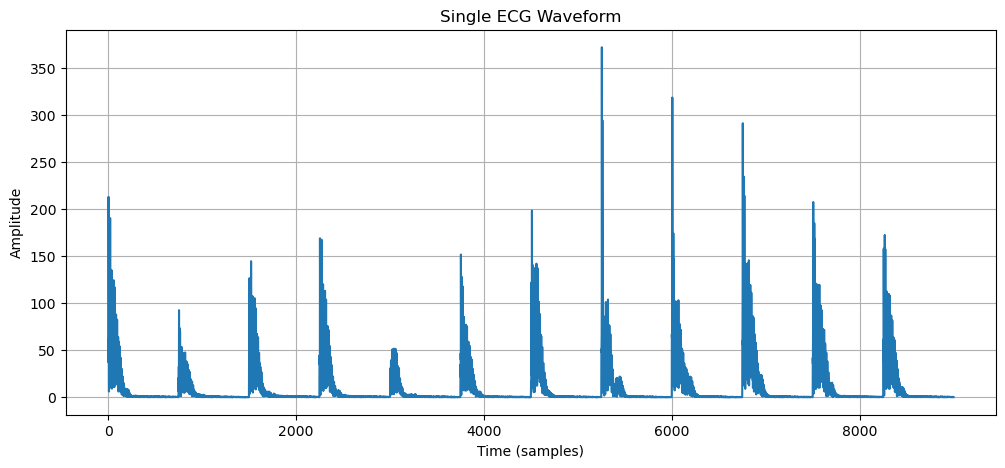

In [3]:
## This code block was not used for the final report

# Select the first row (single ECG waveform)
sample_ecg = data.iloc[0, 1:-1]  # Exclude index and label

# Plot the ECG waveform
plt.figure(figsize=(12, 5))  
plt.plot(sample_ecg.values)  
plt.title('Single ECG Waveform')  
plt.xlabel('Time (samples)')  
plt.ylabel('Amplitude')  
plt.grid(True)  
plt.show()


### 1.3 Feature distribution

The magnitude of the feature values for each lead are visalized in the plots below to examine feature distribution/patterns in the data. The distribution of the data was also examined. 

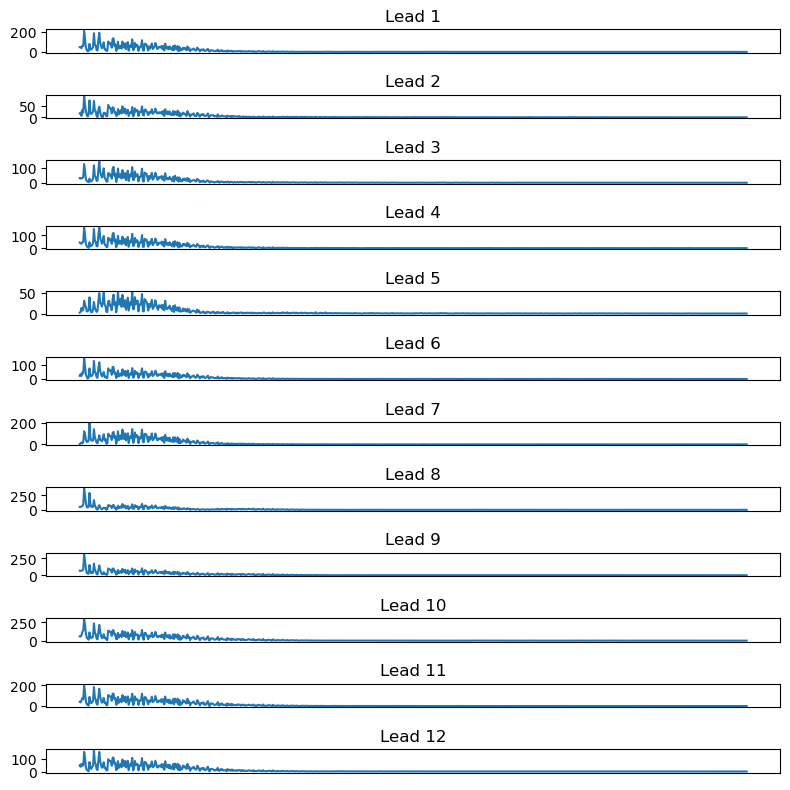

Number of non-normally distributed features: 9000 out of 9000


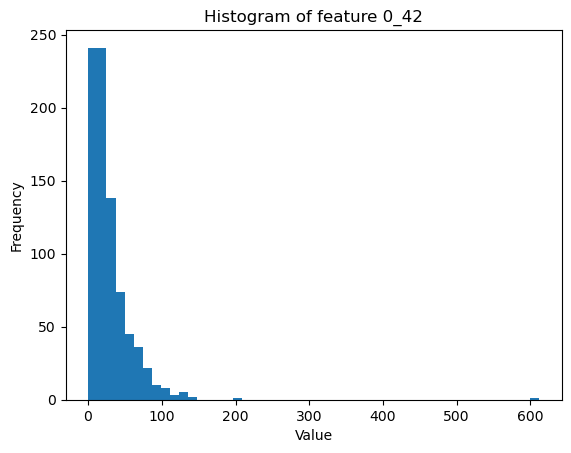

In [4]:
# Select the first row (single ECG waveform)
sample_number = 0  # Index of the sample to visualize, use 0 for a normal ECG and 1 for an abnormal ECG 
#(as the first sample is normal and the second abnormal)
sample_ecg = data.iloc[sample_number, :-1]  # Select first row (first ECG signal) and exclude label

num_leads = 12
lead_size = 750

fig, axes = plt.subplots(num_leads, 1, figsize=(8, 8))
axes = axes.flatten()

# Loop through each lead
for i, ax in enumerate(axes):
    lead_start = i * lead_size       # Calculate the start index of the lead
    lead_end = (i + 1) * lead_size  # Calculate the end index of the lead
    lead = sample_ecg[lead_start:lead_end]  # Extract the lead data

    ax.plot(lead)  # Plot the lead
    ax.set_title(f'Lead {i+1}')  # Add title

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.tight_layout()  # Adjust the subplots to fit into the figure
plt.show()

# Check whether the data is normally distributed
from scipy import stats
non_normal_features = []
p_values = {}

for col in data.columns[:-1]:  # Skip label
    feature_data = data[col].dropna()
    stat, p = stats.normaltest(feature_data)
    p_values[col] = p
    if p < 0.05:
        non_normal_features.append(col)

print(f"Number of non-normally distributed features: {len(non_normal_features)} out of {len(data.columns) - 1}")

import matplotlib.pyplot as plt

random_feature = data.columns[42]  # Choose any index
plt.hist(data[random_feature].dropna(), bins=50)
plt.title(f'Histogram of feature {random_feature}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


### 1.4 Feature correlation

To investigate relationships between features, a correlation matrix was computed.

In [5]:
# Caculate the correlation matrix
subset_of_features = features  
correlation_matrix = subset_of_features.corr()

#Identify highly correlated features
threshold = 0.95
upper = correlation_matrix.where( 
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)) #only upper triangle of the matrix (to avoid checking each pair twice)

to_drop = set()
for column in upper.columns:
    high_corr = upper[column][abs(upper[column]) > threshold].index.tolist() # checks for correlation above the threshold
    for correlated_feature in high_corr:
        if correlated_feature not in to_drop and column not in to_drop:
            to_drop.add(correlated_feature)

print(f"Number of features with correlation to drop (one per correlated pair for which correlation > {threshold}): {len(to_drop)}")

# Drop redundant features
subset_of_features_reduced = subset_of_features.drop(columns=to_drop)
print(f"Number of features that remain: {len(subset_of_features_reduced.columns)}")


Number of features with correlation to drop (one per correlated pair for which correlation > 0.95): 4769
Number of features that remain: 4231


### 1.5 Data (non-)linearity
To determine data linearity, PCA is performed. Before this analysis, the data is first split in a train and test set, using a 80-20 stratified split. Next, PCA is performed and the results are plotted in a scatter plot.

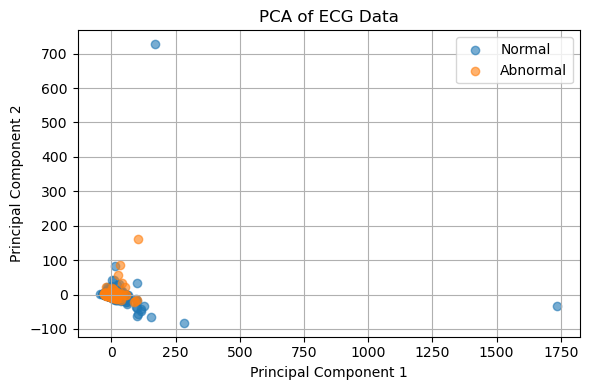

In [6]:
# Standardize the features, This is important for PCA as it relies on distances between points
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2) #reduce to 2 components for visualization
features_pca = pca.fit_transform(features_scaled)

# Plotting results
plt.figure(figsize=(6, 4))
plt.scatter(features_pca[labels.values == 0, 0], features_pca[labels.values == 0, 1], label='Normal', alpha=0.6)
plt.scatter(features_pca[labels.values == 1, 0], features_pca[labels.values == 1, 1], label='Abnormal', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ECG Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Besides PCA, a covariance matrix was computed for each class and the mean absolute difference between covariance matrices was calculated to further determine data linearity.

In [7]:
# Split the data by class
class0 = data[data['label'] == 0]
class1 = data[data['label'] == 1]

# Compute covariance matrices for each class based on the 9000 features
n_features = 9000
cov0 = np.cov(class0.iloc[:, :n_features], rowvar=False)
cov1 = np.cov(class1.iloc[:, :n_features], rowvar=False)

# Calculate mean absolute difference between the covariance matrices
cov_diff = np.abs(cov0 - cov1)
print(f"Mean absolute difference between covariance matrices: {np.mean(cov_diff)}")


Mean absolute difference between covariance matrices: 32.98255583485797


## 2 Preprocessing data

### 2.1 Feature correlation

For determining number of redundant features

In [8]:
# Calculate the correlation matrix
correlation_matrix = features.corr()

#Identify highly correlated features
threshold = 0.88
upper = correlation_matrix.where( 
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)) #only upper triangle of the matrix (to avoid checking each pair twice)

to_drop = set()
for column in upper.columns:
    high_corr = upper[column][abs(upper[column]) > threshold].index.tolist() # checks for correlation above the threshold
    for correlated_feature in high_corr:
        if correlated_feature not in to_drop and column not in to_drop:
            to_drop.add(correlated_feature)

print(f"Number of features with correlation to drop (one per correlated pair for which correlation > {threshold}): {len(to_drop)}")

# Drop redundant features
subset_of_features_reduced = subset_of_features.drop(columns=to_drop)
print(f"Number of features that remain: {len(subset_of_features_reduced.columns)}")

# Splitting the data into training, validation and testing sets
x_train, x_test, y_train, y_test = train_test_split(subset_of_features_reduced, labels, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Train Random Forest with class balancing to determine optimal threshold
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(x_val)
y_prob = rf_model.predict_proba(x_val)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_val, y_prob))

Number of features with correlation to drop (one per correlated pair for which correlation > 0.88): 6931
Number of features that remain: 2069
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       109
           1       0.80      0.33      0.47        24

    accuracy                           0.86       133
   macro avg       0.83      0.66      0.70       133
weighted avg       0.86      0.86      0.84       133


Confusion Matrix:
[[107   2]
 [ 16   8]]

ROC AUC Score: 0.8306574923547401


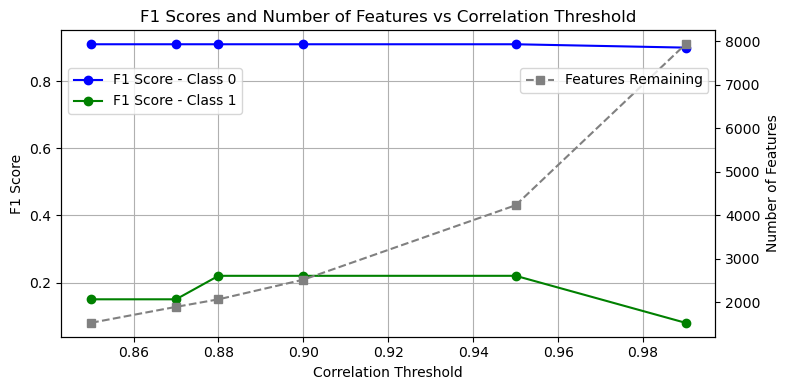

In [9]:
# Visualisation of threshold for dropping correlated features
correlation_data = {
    'threshold': [0.85, 0.87, 0.88, 0.9, 0.95, 0.99],
    'features_remaining': [1530, 1896, 2069, 2521, 4231, 7929],
    'f1_score_0': [0.91, 0.91, 0.91, 0.91, 0.91, 0.90],
    'f1_score_1': [0.15, 0.15, 0.22, 0.22, 0.22, 0.08],
}
correlation_df = pd.DataFrame(correlation_data)

# Create main plot with secondary y-axis
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot F1 scores
ax1.plot(correlation_df['threshold'], correlation_df['f1_score_0'], marker='o', label='F1 Score - Class 0', color='blue')
ax1.plot(correlation_df['threshold'], correlation_df['f1_score_1'], marker='o', label='F1 Score - Class 1', color='green')
ax1.set_xlabel("Correlation Threshold")
ax1.set_ylabel("F1 Score")
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax1.grid(True)

# Plot features remaining on second y-axis
ax2 = ax1.twinx()
ax2.plot(correlation_df['threshold'], correlation_df['features_remaining'], marker='s', linestyle='--', color='gray', label='Features Remaining')
ax2.set_ylabel("Number of Features")
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

# Title and layout
plt.title("F1 Scores and Number of Features vs Correlation Threshold")
plt.tight_layout()
plt.show()

## 3 Feature Selection

In [7]:
# Splits features en labels
X = data.iloc[:, :-1].values  # Alle kolommen behalve de laatste zijn de features
y = data.iloc[:, -1].values   # De laatste kolom is de label (0 of 1)

### 3.1 Inner cross-validation with all feature selection methods

In [8]:
## Function to perform nested cross-validation for feature selection

def nested_cv_feature_selection(X, y, k_features=2100, outer_splits=5, inner_splits=5):
    outer_skf = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)

    # Store scores across all outer folds
    all_outer_scores = {
        'ttest': {'normal': [], 'abnormal': []},
        'kbest': {'normal': [], 'abnormal': []},
        'mi': {'normal': [], 'abnormal': []},
        'all_features': {'normal': [], 'abnormal': []}
    }

    def select_features(method, X_tr, y_tr):
        if method == 'ttest':
            p_values = [stats.ttest_ind(X_tr[y_tr == 0, i], X_tr[y_tr == 1, i])[1]
                        for i in range(X_tr.shape[1])]
            return np.argsort(p_values)[:k_features]
        elif method == 'kbest':
            skb = SelectKBest(score_func=f_classif, k=k_features)
            skb.fit(X_tr, y_tr)
            return skb.get_support(indices=True)
        elif method == 'mi':
            mi = mutual_info_classif(X_tr, y_tr)
            return np.argsort(mi)[-k_features:]

    for outer_fold, (train_idx, test_idx) in enumerate(outer_skf.split(X, y)):
        print(f"\n=== Outer Fold {outer_fold + 1} ===")

        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]

        inner_skf = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)
        method_scores = {
            'ttest': {'normal': [], 'abnormal': []},
            'kbest': {'normal': [], 'abnormal': []},
            'mi': {'normal': [], 'abnormal': []},
            'all_features': {'normal': [], 'abnormal': []}
        }

        for method in method_scores.keys():
            print(f"\n  Evaluating Feature Selection: {method}")
            for inner_train_idx, val_idx in inner_skf.split(X_train_outer, y_train_outer):
                X_tr, X_val = X_train_outer[inner_train_idx], X_train_outer[val_idx]
                y_tr, y_val = y_train_outer[inner_train_idx], y_train_outer[val_idx]

                scaler = StandardScaler()
                X_tr = scaler.fit_transform(X_tr)
                X_val = scaler.transform(X_val)

                if method != 'all_features':
                    selected_idx = select_features(method, X_tr, y_tr)
                    X_tr_sel = X_tr[:, selected_idx]
                    X_val_sel = X_val[:, selected_idx]
                else:
                    X_tr_sel = X_tr
                    X_val_sel = X_val

                rf = RandomForestClassifier(random_state=42)
                rf.fit(X_tr_sel, y_tr)
                preds = rf.predict(X_val_sel)
                f1s = f1_score(y_val, preds, average=None, labels=[0, 1])
                best_f1_normal = f1s[0]
                best_f1_abnormal = f1s[1]

                method_scores[method]['normal'].append(best_f1_normal)
                method_scores[method]['abnormal'].append(best_f1_abnormal)

            # Average F1 scores across inner folds for this method
            f1_normal_avg = np.mean(method_scores[method]['normal'])
            f1_abnormal_avg = np.mean(method_scores[method]['abnormal'])
            print(f"  Avg F1 - Normal: {f1_normal_avg:.4f} | Abnormal: {f1_abnormal_avg:.4f}")

            # Store for overall summary across all outer folds
            all_outer_scores[method]['normal'].append(f1_normal_avg)
            all_outer_scores[method]['abnormal'].append(f1_abnormal_avg)

    # Summary across all outer folds
    print("\n=== Overall Summary Across All Outer Folds ===")
    for method in all_outer_scores.keys():
        overall_n_avg = np.mean(all_outer_scores[method]['normal'])
        overall_a_avg = np.mean(all_outer_scores[method]['abnormal'])
        print(f"{method:>10} → Avg Normal F1: {overall_n_avg:.4f} | Avg Abnormal F1: {overall_a_avg:.4f}")

nested_cv_feature_selection(X, y)


=== Outer Fold 1 ===

  Evaluating Feature Selection: ttest
  Avg F1 - Normal: 0.9101 | Abnormal: 0.2537

  Evaluating Feature Selection: kbest
  Avg F1 - Normal: 0.9067 | Abnormal: 0.2259

  Evaluating Feature Selection: mi
  Avg F1 - Normal: 0.9114 | Abnormal: 0.2323

  Evaluating Feature Selection: all_features
  Avg F1 - Normal: 0.9075 | Abnormal: 0.1609

=== Outer Fold 2 ===

  Evaluating Feature Selection: ttest
  Avg F1 - Normal: 0.9107 | Abnormal: 0.2098

  Evaluating Feature Selection: kbest
  Avg F1 - Normal: 0.9079 | Abnormal: 0.2004

  Evaluating Feature Selection: mi
  Avg F1 - Normal: 0.9094 | Abnormal: 0.1651

  Evaluating Feature Selection: all_features
  Avg F1 - Normal: 0.9033 | Abnormal: 0.1282

=== Outer Fold 3 ===

  Evaluating Feature Selection: ttest
  Avg F1 - Normal: 0.9128 | Abnormal: 0.2787

  Evaluating Feature Selection: kbest
  Avg F1 - Normal: 0.9112 | Abnormal: 0.2526

  Evaluating Feature Selection: mi
  Avg F1 - Normal: 0.9151 | Abnormal: 0.2500

  Ev

In [ ]:
# Function to evaluate optimization-based feature selection
# This was put in a separate code block to reduce computing time while testing
# Genetic algorithm-based feature selection 

# Set random seed for reproducibility
random.seed(42)  # Set for random module
np.random.seed(42)  # Set for numpy module, used in data scaling, etc.

# Function to run Genetic Algorithm-based feature selection
def ga_feature_selection(X_train_scaled, y_train):
    # Set random seed for GA
    random.seed(42)
    
    # Define the evaluation function
    def evaluate(individual):
        # Individual is a binary list representing selected features of a potential solution

        # Convert binary list to feature indices
        selected_features = [i for i, bit in enumerate(individual) if bit == 1]
        
        # If no features are selected, return worst fitness
        if len(selected_features) == 0:
            return 0.0,
        
        # Select the features from the training data
        X_selected = X_train_scaled[:, selected_features]

        # Train Random Forest on selected features
        model = RandomForestClassifier(random_state=42)
        model.fit(X_selected, y_train)
        
        # Evaluate the accuracy of the model
        accuracy = model.score(X_selected, y_train)
        
        return accuracy,  # Return the accuracy as fitness score

    # Set up Genetic Algorithm using DEAP
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness (so accuracy)
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMax)  # Create individual which represents a solution

    toolbox = base.Toolbox()  # Toolbox to hold genetic operations
    toolbox.register("attr_bool", random.randint, 0, 1)  # How to create a bit for the individual
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_scaled.shape[1])  # Create an individual with n features
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Creates a population of individuals
    toolbox.register("mate", tools.cxTwoPoint)  # Crossover operation which combines two individuals
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Randomly flips bits in the individual with a probability of 0.05
    toolbox.register("select", tools.selTournament, tournsize=3)  # Selects individuals for the next generation using tournament selection
    toolbox.register("evaluate", evaluate)

    # Run the Genetic Algorithm
    population = toolbox.population(n=5)  # Create a population of n individuals
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=5, verbose=False)  # ngen is the number of iterations of the GA

    # Extract the best individual after the GA completes
    best_individual = tools.selBest(population, k=1)[0]  # Select the best individual (solution)
    selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

    # Print the number of features selected
    print(f"    → GA selected {len(selected_features)} features")
    
    return selected_features

# Function to run nested cross-validation with GA-based feature selection
def nested_cv_with_ga(X, y):
    outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Outer CV for estimating generalization

    all_f1_normal = []     # Store average F1 per outer fold for class 0
    all_f1_abnormal = []   # Store average F1 per outer fold for class 1

    for outer_fold, (train_idx, test_idx) in enumerate(outer_skf.split(X, y)):
        print(f"\n=== Outer Fold {outer_fold + 1} ===")

        # Split into outer train/test
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]

        inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Inner CV for model/feature tuning
        f1_normal_scores = []
        f1_abnormal_scores = []

        for _, (inner_train_idx, val_idx) in enumerate(inner_skf.split(X_train_outer, y_train_outer)):
            X_train, X_val = X_train_outer[inner_train_idx], X_train_outer[val_idx]
            y_train, y_val = y_train_outer[inner_train_idx], y_train_outer[val_idx]

            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set
            X_val_scaled = scaler.transform(X_val)          # Use the same scaler for the validation set

            # Feature Selection using the GA method in the inner CV
            selected_features_ga = ga_feature_selection(X_train_scaled, y_train)

            # Select the features based on the GA result
            X_train_sel = X_train_scaled[:, selected_features_ga]
            X_val_sel = X_val_scaled[:, selected_features_ga]

            # Train the model with the selected features
            rf = RandomForestClassifier(random_state=42)  # Set random_state for reproducibility
            rf.fit(X_train_sel, y_train)

            # Evaluate the performance on the validation set
            y_pred = rf.predict(X_val_sel)

            # Calculate F1 scores for both classes (normal and abnormal)
            f1_rf = f1_score(y_val, y_pred, average=None, labels=[0, 1])

            # Append the F1 scores to the lists
            f1_normal_scores.append(f1_rf[0])
            f1_abnormal_scores.append(f1_rf[1])

        # Calculate and print the average F1 scores for this outer fold
        avg_f1_normal = np.mean(f1_normal_scores)
        avg_f1_abnormal = np.mean(f1_abnormal_scores)
        print(f"→ Outer Fold {outer_fold + 1} Average F1: Normal = {avg_f1_normal:.4f}, Abnormal = {avg_f1_abnormal:.4f}")

        # Store the outer fold average scores
        all_f1_normal.append(avg_f1_normal)
        all_f1_abnormal.append(avg_f1_abnormal)

    # Final summary after all outer folds
    print("\n=== GA Feature Selection Summary Across All Outer Folds ===")
    print(f"Average Normal F1:   {np.mean(all_f1_normal):.4f}")
    print(f"Average Abnormal F1: {np.mean(all_f1_abnormal):.4f}")

nested_cv_with_ga(X, y)


=== Outer Fold 1 ===
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
→ Outer Fold 1 Average F1: Normal = 0.9060, Abnormal = 0.1358

=== Outer Fold 2 ===
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
→ Outer Fold 2 Average F1: Normal = 0.9035, Abnormal = 0.1186

=== Outer Fold 3 ===
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
→ Outer Fold 3 Average F1: Normal = 0.9083, Abnormal = 0.1887

=== Outer Fold 4 ===
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
    → GA selected 4529 features
→ Outer Fold 4 Average F1: Normal = 0.9041, Abnormal = 0.0764

=== Outer Fold 5 ===
  

### 3.2 Select best performing feature selection method

In [10]:
# Best feature selection method of inner cv is kbest
def kbest_selector(X, y, k):

    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)

    # Get the boolean mask of selected features and convert it to indices
    mask = selector.get_support()
    return np.where(mask)[0]


## 4 Classifiers

### 4.1 Random forest classifier

In [ ]:
## Function to perform random forest with inner and outer cross-validation

def outer_cv_pipeline_rf(X, y, feature_selection_method, k_features=2100):
    
    y_tests_all = []
    y_probas_all = []

    #Variable to store ROC-curves of each fold
    roc_folds = []
    
    #Variable to store Precision-Recall curve of each fold
    pr_folds = []

    # Outer CV Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Randomized Search for Random Forest
    def random_search_rf(X_tr, y_tr):
        rf = RandomForestClassifier(random_state=42)
        param_dist = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10],
            'min_samples_split': [15, 20, 30],
            'min_samples_leaf': [30, 40, 60],
            'max_features': ['sqrt', None],
            'bootstrap': [True],
            'class_weight': ['balanced']
        }
        random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=30, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(X_tr, y_tr)
        return random_search.best_estimator_

    # Initialize lists to store results for each fold
    rf_results_normal = []
    rf_results_abnormal = []

    # Outer Cross-validation loop
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # --- Scale the data (fit on training, transform on both train/test) ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set
        X_test_scaled = scaler.transform(X_test)        # Use the same scaler for the test set

        # --- Feature Selection using the specified method ---
        selected_idx = feature_selection_method(X_train_scaled, y_train, k_features)
        X_train_sel = X_train_scaled[:, selected_idx]
        X_test_sel = X_test_scaled[:, selected_idx]
        
        # --- Inner Cross-validation (for model optimization using RandomizedSearchCV) ---
        skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for inner_train_idx, inner_val_idx in skf_inner.split(X_train_sel, y_train):
            X_inner_train, X_inner_val = X_train_sel[inner_train_idx], X_train_sel[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            # RandomizedSearch for Random Forest
            rf_model = random_search_rf(X_inner_train, y_inner_train)

            # --- Train model and get F1 scores for normal (0) and abnormal (1) classes ---
            rf_preds = rf_model.predict(X_inner_val)

            # F1 scores for both classes (normal and abnormal)
            f1_rf = f1_score(y_inner_val, rf_preds, average=None, labels=[0, 1])

            # Store results for this fold
            rf_results_normal.append(f1_rf[0])
            rf_results_abnormal.append(f1_rf[1])
        
        # --- Final evaluation on the outer test set after optimization ---
        rf_model_final = random_search_rf(X_train_sel, y_train)
        rf_preds_test = rf_model_final.predict(X_test_sel)

        # F1 scores for Random Forest on outer test set
        f1_rf_test = f1_score(y_test, rf_preds_test, average=None, labels=[0, 1])

        # Probabilistische voorspellingen voor ROC curve
        y_test_proba = rf_model_final.predict_proba(X_test_sel)[:, 1]

        # Verzamel voor ROC-curve
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        roc_folds.append((fpr, tpr, roc_auc))  # Opslaan voor elke fold

        # Verzamel voor Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
        pr_auc = auc(recall, precision)  # AUC voor Precision-Recall curve
        pr_folds.append((precision, recall, pr_auc))  # Opslaan voor elke fold

        # Verzamel testlabels en probabilistische voorspellingen
        y_tests_all.extend(y_test)
        y_probas_all.extend(y_test_proba)

        # Print results for outer fold evaluation
        print(f"\nOuter Fold Evaluation Results for Random Forest:")
        print(f"Random Forest: Normal F1: {f1_rf_test[0]:.4f} | Abnormal F1: {f1_rf_test[1]:.4f}")

    # --- Final Summary after all outer folds ---
    print("\n Final Summary of All Outer Folds for Random Forest:")
    print(f"Random Forest: Average Normal F1: {np.mean(rf_results_normal):.4f} | Average Abnormal F1: {np.mean(rf_results_abnormal):.4f}")

    return roc_folds, pr_folds #Return de verzamelde ROC en Precision-Recall gegevens

# Use Random Forest for evaluation
roc_folds, pr_folds = outer_cv_pipeline_rf(X, y, kbest_selector)


Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.8826 | Abnormal F1: 0.3529

Outer Fold Evaluation Results for Random Forest:
Random Forest: Normal F1: 0.8913 | Abnormal F1: 0.4643


4.1.2 Plots RF classifier

In [ ]:
## ROC curve
# Plot de ROC-curve voor elke fold met transparante lijnen
for fpr, tpr, roc_auc in roc_folds:
    plt.plot(fpr, tpr, lw=2, alpha=0.3, color='blue')  # Transparante lijn voor elke fold

# Bereken en plot de gemiddelde ROC-curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_folds], axis=0)
mean_roc_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='red', lw=2, label=f'Mean ROC curve (AUC = {mean_roc_auc:.4f})')

# Voeg de diagonale lijn toe
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Outer CV Fold and Mean ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'roc_folds' is not defined

In [ ]:
## Precision-Recoil curve
plt.figure(figsize=(8, 6))

# Plot de Precision-Recall curve voor elke fold met transparante lijnen
for precision, recall, pr_auc in pr_folds:
    plt.plot(recall, precision, lw=2, alpha=0.3, color='blue')  # Transparante lijn voor elke fold

# Bereken en plot de gemiddelde Precision-Recall curve
mean_recall = np.linspace(0, 1, 100)
mean_precision = np.mean([np.interp(mean_recall, recall, precision) for recall, precision, _ in pr_folds], axis=0)
mean_pr_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, color='red', lw=2, label=f'Mean Precision-Recall curve (AUC = {mean_pr_auc:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Outer CV Fold and Mean Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'pr_folds' is not defined

<Figure size 576x432 with 0 Axes>

In [ ]:
## Learning curve

# --- Learning Curve met ROC AUC ---
train_sizes, train_scores, val_scores = learning_curve(
    estimator= random_search.best_estimator_,   # Beste model uit RandomizedSearchCV
    X= X_train_ttest,                           # Geselecteerde features na T-test
    y= y_train,                                 # Trainlabels
    train_sizes=np.linspace(0.1, 1.0, 10),     # Verschillende hoeveelheden trainingsdata
    cv=5,                                      # 3-voudige cross-validation
    scoring='roc_auc',                         # ROC AUC score gebruiken
    n_jobs=-1,                                 # Gebruik alle cores voor parallelisatie
    shuffle=True,                              # Shuffle de data om een betere generalisatie te krijgen
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plotten van de Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training ROC AUC", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation ROC AUC", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (Random Forest with T-test Selected Features)")
plt.xlabel("Training Set Size")
plt.ylabel("ROC AUC Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.2 SVM classifier

In [ ]:
## Function to perform SVM with inner and outer cross-validation

def outer_cv_pipeline_svm(X, y, feature_selection_method, k_features=2100):
    
    # Outer CV Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    
    # Randomized Search for SVM
    def random_search_svm(X_tr, y_tr):
        param_dist = {
            'C': [0.1, 1, 10, 100], # Try multiple values for the Slack
            'gamma': ['scale', 0.01, 0.1, 1], # Try multiple gamma values
            'kernel': ['rbf']
        }
        svm = SVC(probability=True, class_weight='balanced', random_state=42) # account for class imbalance
        search = RandomizedSearchCV(
            estimator=svm,
            param_distributions=param_dist,
            n_iter=5,
            cv=3,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0,
            random_state=42
        )
        search.fit(X_tr, y_tr)
        return search.best_estimator_

    # Initialize lists to store results for each fold
    svm_results_normal = []
    svm_results_abnormal = []

    # Outer Cross-validation loop
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale the data (fit on training, transform on both train/test)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set
        X_test_scaled = scaler.transform(X_test)        # Use the same scaler for the test set

        # Feature Selection using the specified method
        selected_idx = feature_selection_method(X_train_scaled, y_train, k_features)
        X_train_sel = X_train_scaled[:, selected_idx]
        X_test_sel = X_test_scaled[:, selected_idx]
        
        # Inner Cross-validation, this part is used for optimizing the model
        skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold = 1
        for inner_train_idx, inner_val_idx in skf_inner.split(X_train_sel, y_train):
            X_inner_train, X_inner_val = X_train_sel[inner_train_idx], X_train_sel[inner_val_idx]
            y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
            
            # RandomizedSearch for SVM
            svm_model = random_search_svm(X_inner_train, y_inner_train)

            # Train model and get F1 scores for normal (0) and abnormal (1) classes
            svm_preds = svm_model.predict(X_inner_val)

            # F1 scores for both classes (normal and abnormal)
            f1_svm = f1_score(y_inner_val, svm_preds, average=None, labels=[0, 1])

            # Store results for this fold
            svm_results_normal.append(f1_svm[0])
            svm_results_abnormal.append(f1_svm[1])
            
        
        # Final evaluation on the outer test set after optimization
        svm_model_final = random_search_svm(X_train_sel, y_train)
        svm_preds_test = svm_model_final.predict(X_test_sel)

        # F1 scores for SVM on outer test set
        f1_svm_test = f1_score(y_test, svm_preds_test, average=None, labels=[0, 1])

        # Confusion matrix
        cm = confusion_matrix(y_test, svm_preds_test)
        labels = ['Normal', 'Abnormal']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - Fold {fold}')  
        plt.tight_layout()
        plt.show()

        # Print results for outer fold evaluation
        print(f"\nOuter Fold Evaluation Results for SVM:")
        print(f"SVM: Normal F1: {f1_svm_test[0]:.4f} | Abnormal F1: {f1_svm_test[1]:.4f}")

        fold += 1

    # Final Summary after all outer folds
    print("\n Final Summary of All Outer Folds for SVM:")
    print(f"SVM: Average Normal F1: {np.mean(svm_results_normal):.4f} | Average Abnormal F1: {np.mean(svm_results_abnormal):.4f}")

# Use SVM for evaluation
outer_cv_pipeline_svm(X, y, kbest_selector)

NameError: name 'X' is not defined

### 4.3 Flipped SVM classifier

In [ ]:
## Function to perform flipped SVM with inner and outer cross-validation

def outer_cv_pipeline_svm_flipped(X, y, feature_selection_method, k_features=2100):
    # Flip the labels: 1 = Normal, 0 = Abnormal
    y = 1 - y

    # Outer CV Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized Search for SVM
    def random_search_svm(X_tr, y_tr):
        param_dist = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.01, 0.1, 1],
            'kernel': ['rbf']
        }
        svm = SVC(probability=True, class_weight='balanced', random_state=42)
        search = RandomizedSearchCV(
            estimator=svm,
            param_distributions=param_dist,
            n_iter=3,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0,
            random_state=42
        )
        search.fit(X_tr, y_tr)
        return search.best_estimator_

    svm_results_normal = []
    svm_results_abnormal = []
    fold = 1

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        selected_idx = feature_selection_method(X_train_scaled, y_train, k_features)
        X_train_sel = X_train_scaled[:, selected_idx]
        X_test_sel = X_test_scaled[:, selected_idx]

        svm_model = random_search_svm(X_train_sel, y_train)
        y_prob = svm_model.predict_proba(X_test_sel)[:, 1]  # Probability of being NORMAL
        threshold = 0.65
        y_pred_flipped = (y_prob >= threshold).astype(int)

        # Flip predictions and truth back for interpretation: 1 = Abnormal, 0 = Normal
        y_test_original = 1 - y_test
        y_pred_original = 1 - y_pred_flipped

        f1 = f1_score(y_test_original, y_pred_original, average=None, labels=[0, 1])
        svm_results_normal.append(f1[0])
        svm_results_abnormal.append(f1[1])

        cm = confusion_matrix(y_test_original, y_pred_original)
        labels = ['Normal', 'Abnormal']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix (Fold {fold})')
        plt.tight_layout()
        plt.show()

        y_prob_abnormal = 1 - y_prob  # get probability of being Abnormal
        fpr, tpr, _ = roc_curve(y_test_original, y_prob_abnormal)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Fold {fold})')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nOuter Fold {fold} Evaluation:")
        print(f"F1 - Normal: {f1[0]:.4f} | F1 - Abnormal: {f1[1]:.4f} | AUC: {roc_auc:.4f}")
        fold += 1

    print("\nFinal Summary of All Outer Folds:")
    print(f"Average F1 - Normal: {np.mean(svm_results_normal):.4f} | Average F1 - Abnormal: {np.mean(svm_results_abnormal):.4f}")

outer_cv_pipeline_svm_flipped(X, y, kbest_selector)